In [3]:
!pip install --upgrade --editable gym-env

Obtaining file:///C:/Users/samru/anaconda3/lectures/CS698_DeepRL/Project/ForagingReplenishingPatches-main/gym-env
  Attempting uninstall: gym-env
    Found existing installation: gym-env 1.0.0
    Uninstalling gym-env-1.0.0:
      Successfully uninstalled gym-env-1.0.0
  Running setup.py develop for gym-env


In [1]:
import gym
import gym_env
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

env = gym.make('foraging-replenishing-patches-v0')
env.reset()

for i in range(300):
    action = np.random.randint(9)
    state, reward, done, _ = env.step(action)
    print(action, state, reward, done)
    if done:
        break


0 0 0 False
5 5 0 False
7 7 0 False
7 7 0 False
3 3 0 False
6 6 0 False
1 1 0 False
6 6 0 False
2 2 0 False
8 2 63.0 False
0 0 63.0 False
5 5 63.0 False
1 1 63.0 False
4 4 63.0 False
1 1 63.0 False
8 1 129.60000000000002 False
3 3 129.60000000000002 False
1 1 129.60000000000002 False
8 1 189.00000000000003 False
7 7 189.00000000000003 False
7 7 189.00000000000003 False
1 1 189.00000000000003 False
3 3 189.00000000000003 False
3 3 189.00000000000003 False
5 5 189.00000000000003 False
7 7 189.00000000000003 False
1 1 189.00000000000003 False
2 2 189.00000000000003 False
1 1 189.00000000000003 False
7 7 189.00000000000003 False
5 5 189.00000000000003 False
7 7 189.00000000000003 False
7 7 189.00000000000003 False
1 1 189.00000000000003 False
8 1 242.10000000000002 False
4 4 242.10000000000002 False
8 4 319.5 False
3 3 319.5 False
4 4 319.5 False
3 3 319.5 False
8 3 319.5 False
3 3 319.5 False
2 2 319.5 False
4 4 319.5 False
4 4 319.5 False
4 4 319.5 False
3 3 319.5 False
0 0 319.5 False
0

In [2]:
def init_env(block_type):
    
    env = gym.make('foraging-replenishing-patches-v0',block_type=block_type)
    state=env.reset()
    estimated_rewards=np.array([start_reward]*(env.action_space.n-1))
    visited=np.array([0]*(env.action_space.n-1))
    replenish_rate=np.array([[0.,0.,0.]]*(env.action_space.n-1))
    
    action=np.random.randint(8) #go to random place
    state, current_reward, done, _ = env.step(action)
    state, current_reward, done, _ = env.step(8) #harvest
    rewards=[current_reward]
    visited[state]=1
    updated=False
    
    return env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated

In [3]:
def get_distance(state,new_states):

    distance=[]
    for new_state in new_states:
        if abs(new_state-state)<=4:
            d=abs(new_state-state)
        else:
            d=8-abs(new_state-state)
        
        if d==2:
            d=1*np.sqrt(2+np.sqrt(2))
        elif d==3:
             d=1*(1+np.sqrt(2))
        elif d==4:
            d=1*np.sqrt(4+2*np.sqrt(2))
            
        distance.append(d)

    return np.array(distance)

**Probability of leaving on each trial**  
 
$P=\frac {1}{1+exp(-[c+\beta(r_t-T_t)])}  $

$r_t$: current reward received from the environment  
$T_t$: current threshold decided by the agent    
$c$: Indicate tendency to continue at current patch irrespective of reward and threshold  
$\beta$: Sensitivity to difference between reward and threshold 

In [4]:
def exploit_or_explore(r,T,c=0.5, beta=0.5):
    
    return 1 / (1 + np.exp(-(c + beta*(r - T)))) #probability of staying 

In [5]:
import copy
def select_action(p, s,estimated_rewards=[], type='greedy'):
    
    if np.random.uniform()<p:
        action=8 #harvest
        state, total_reward, done, _ = env.step(action)
        #staying at the patch
        change=False
        leave_time=None 
    else:
        #leaving the patch
        change=True
        leave_time=env.time_elapsed
        
        temp_estimated_rewards=copy.deepcopy(estimated_rewards)
        temp_estimated_rewards[s]= 0 #ensure the same state is not selected again
    
        if type=='greedy':
            max_states=np.where(temp_estimated_rewards==max(temp_estimated_rewards))[0] #select action greedily
            d=get_distance(s,max_states)
            d=(max(d)-d)+min(d)
            action=np.random.choice(max_states,p=d/sum(d)) #random from best options weighted by distance
        elif type=='softmax':
            p=np.exp(temp_estimated_rewards)/sum(np.exp(temp_estimated_rewards))
            action=np.random.choice(np.arange(8),p=p)
        elif type=='replenish':
             new_estimated_rewards=(env.time_elapsed-replenish_rate[:,0])*replenish_rate[:,1] + estimated_rewards
             p=np.exp(temp_estimated_rewards)/sum(np.exp(temp_estimated_rewards))
             action=np.random.choice(np.arange(8),p=p)
            
        state, total_reward, done, _ = env.step(action) #go to a new place
        state, total_reward, done, _ = env.step(8) #harvest

    return state, total_reward, done,change, leave_time

In [6]:
def get_threshold(current_reward, estimated_rewards,w=0.2,distance=False):
    
    distance_cost=get_distance(state,np.arange(8))*current_reward
    if distance==False:
        w=0
    T=max(np.delete(estimated_rewards-w*distance_cost,state)) #take maximum value available from other states as threshold
    return T

In [7]:
def add_noise(estimated_rewards,visited,new_state,noise_mean,noise_std):

    #noise while storing
    if sum(visited)>1: #if visited more than 1 state
            visited[new_state]=0
            #add noise to visited states except current state
            estimated_rewards[np.where( visited== 1)[0]] += np.random.normal(loc=noise_mean, scale=noise_std)
            visited[new_state]=1
    return estimated_rewards

In [8]:
def update_estimated_rewards(estimated_rewards,visited,rewards,global_reward,updated=True,k=3,alpha_global=0.9,type='global'): 
        
        if type=='local':
            #learn the estimated rewards
            if not updated and len(rewards)>k+1: 
                if (np.diff(rewards[-k+1:])>0).all(): #if my last k rewards are positive
                    new_estimate=np.diff(rewards[-k+1:]).mean() #take mean of last k rewards as new estimate
                    estimated_rewards[np.where( visited== 0)[0]]=new_estimate #updated the estimated rewards
                    updated=True 
        
        elif type=='global':
            #use global reward as estimates for not visited states
            current_reward=rewards[-1]-rewards[-2]
            global_reward+=alpha_global*(current_reward-global_reward) #update global reward based on the current reward received
            estimated_rewards[np.where( visited== 0)[0]]=global_reward 
            
        return estimated_rewards,global_reward

In [9]:
def ReplenishRate_update(env,rewards,leave_time,replenish_rate,prev_state,new_state,estimated_rewards,visited):
    
    leave_reward=rewards[-2]-rewards[-3]
    current_reward=rewards[-1]-rewards[-2]
  
    #leaving state
    replenish_rate[prev_state][0]=leave_time
    replenish_rate[prev_state][2]=leave_reward 

    #new state
    if visited[new_state]:
        old_time=replenish_rate[new_state][0]
        old_reward=replenish_rate[new_state][2]
        
        #if the agent moves to other states and comes back before the reward is replenished, replenishment rate is negative
        if env.time_elapsed-old_time>20: 
            replenish_rate[new_state][1]= (current_reward-old_reward)/(env.time_elapsed-old_time)
            #replenish_rate[new_state][1]= (current_reward-estimated_rewards[new_state])/(env.time_elapsed-old_time)
        
    return replenish_rate

In [10]:
def add_replenish(replenish_rate,estimated_rewards,new_state,r=0):
    
    #add replenishment to rewards
        add_reward=[0 if i==new_state else 1 for i in range(len(estimated_rewards))]*replenish_rate[:,1]
        estimated_rewards+=r*add_reward 
        
        return estimated_rewards

In [11]:
#hyperparams

start_reward=100. #arbitrarily set for block-1, will be the previous global estimate for blocks 2 and 3
alpha_local=0.99
k=3
noise_mean=0.2
noise_std=1
global_reward=50
alpha_global=0.9
episodes=50
block_type=1

In [12]:
#running the agent
total_rewards=[]
Rrates=[]

for e in range(episodes):
        done=False
        env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated=init_env(block_type=block_type)
        while not done:

            estimated_rewards[state]+= alpha_local*(current_reward-estimated_rewards[state]) #change estimated reward only for current state
            T=get_threshold(current_reward, estimated_rewards,w=0.2, distance=False) #get threshold to take a leave/stay decision
            p=exploit_or_explore(current_reward,T,c=1, beta=0.5) #get probabilitity of exploiting 
            new_state, total_reward, done, change, leave_time=select_action(p, state,estimated_rewards, type='greedy') 
            rewards.append(total_reward)
            current_reward=rewards[-1]-rewards[-2]
            #add noise over time for visisted states
            estimated_rewards=add_noise(estimated_rewards,visited,new_state,noise_mean,noise_std)
            
            #for all non-visited states
            estimated_rewards,global_reward=update_estimated_rewards(estimated_rewards,visited,rewards,global_reward,updated,k,alpha_global,type='local')
            
            if change:
                #update replenishment
                if len(rewards)>2:
                    replenish_rate=ReplenishRate_update(env,rewards,leave_time,replenish_rate,state,new_state,estimated_rewards,visited)
                visited[new_state]=1
                
            #add replenishment
            estimated_rewards=+add_replenish(replenish_rate,estimated_rewards,new_state,r=0)  
            
            state=new_state

        Rrates.append(np.round(replenish_rate[:,1],1))
        total_rewards.append(rewards[-1])
        

#### Plot

Mean reward in block 1 for 50 episodes= 19553.615999999995


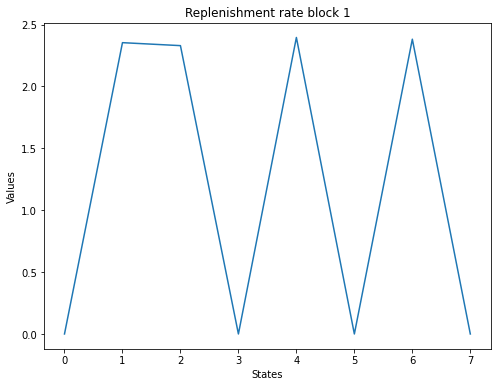

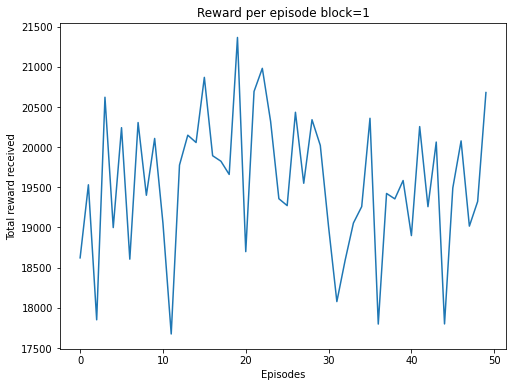

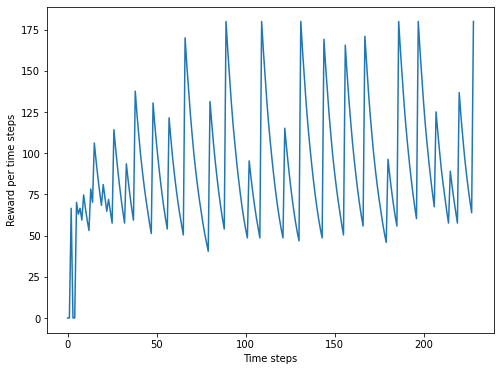

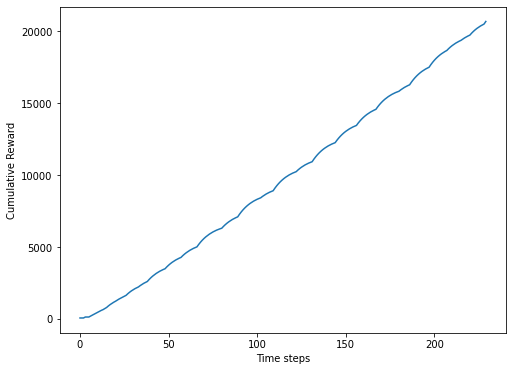

In [15]:
print(f'Mean reward in block {env.block_type} for {episodes} episodes= {np.mean(total_rewards)}')

plt.figure(figsize=(8,6))
rep_rate=np.array(Rrates).mean(axis=0)
plt.plot(np.arange(8),rep_rate)
plt.title(f'Replenishment rate block {env.block_type}')
plt.xlabel(f'States')
plt.ylabel('Values')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(np.arange(episodes),total_rewards)
plt.title(f'Reward per episode block={env.block_type}')
plt.xlabel(f'Episodes')
plt.ylabel('Total reward received')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(np.diff(rewards))),np.diff(rewards))
plt.ylabel('Reward per time steps')
plt.xlabel('Time steps')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(rewards)),rewards)
plt.ylabel('Cumulative Reward')
plt.xlabel('Time steps')
plt.show()